In [1]:
import os, numpy as np, pandas as pd
from glob import glob
from saspt import StateArray, StateArrayDataset, RBME, load_detections
import re
from matplotlib import pyplot as plt

In [2]:
ls ../spt

1.csv*   19.csv*  28.csv*  37.csv*  46.csv*  55.csv*  64.csv*
1.nd2*   19.nd2*  28.nd2*  37.nd2*  46.nd2*  55.nd2*  64.nd2*
10.csv*  2.csv*   29.csv*  38.csv*  47.csv*  56.csv*  65.csv*
10.nd2*  2.nd2*   29.nd2*  38.nd2*  47.nd2*  56.nd2*  65.nd2*
11.csv*  20.csv*  3.csv*   39.csv*  48.csv*  57.csv*  66.csv*
11.nd2*  20.nd2*  3.nd2*   39.nd2*  48.nd2*  57.nd2*  66.nd2*
12.csv*  21.csv*  30.csv*  4.csv*   49.csv*  58.csv*  67.csv*
12.nd2*  21.nd2*  30.nd2*  4.nd2*   49.nd2*  58.nd2*  67.nd2*
13.csv*  22.csv*  31.csv*  40.csv*  5.csv*   59.csv*  7.csv*
13.nd2*  22.nd2*  31.nd2*  40.nd2*  5.nd2*   59.nd2*  7.nd2*
14.csv*  23.csv*  32.csv*  41.csv*  50.csv*  6.csv*   8.csv*
14.nd2*  23.nd2*  32.nd2*  41.nd2*  50.nd2*  6.nd2*   8.nd2*
15.csv*  24.csv*  33.csv*  42.csv*  51.csv*  60.csv*  9.csv*
15.nd2*  24.nd2*  33.nd2*  42.nd2*  51.nd2*  60.nd2*  9.nd2*
16.csv*  25.csv*  34.csv*  43.csv*  52.csv*  61.csv*  runTrackingAll.py*
16.nd2*  25.nd2*  34.nd2*  43.nd2*  52.nd2*  61.nd2*
17.csv*  26.

In [4]:
# read in all files from the dataset, and perform a StateArray analysis on the combined data.

nfiles = 67
basefname = '../spt/%d.csv'
input_files = []
for j in range(1,nfiles+1):
    input_files.append(basefname % j)
detections = load_detections(*input_files)
settings = dict(
    likelihood_type = RBME,
    pixel_size_um = 0.16,
    frame_interval = 0.00748,
    focal_depth = 0.7,
    start_frame = 0,
    progress_bar = True,
    sample_size = 20000,
)
SA = StateArray.from_detections(detections, **settings)
print(SA)
print("Trajectory statistics:")
for k, v in SA.trajectories.processed_track_statistics.items():
    print(f"{k : <20} : {v}")
prior_occs = SA.prior_occs
naive_occs = SA.naive_occs
posterior_occs = SA.posterior_occs
marginal_posterior_occs = SA.marginalize_on_diff_coef(posterior_occs)


StateArray:
  likelihood_type   : rbme
  n_tracks          : 20000
  n_jumps           : 83857
  parameter_names   : ('diff_coef', 'loc_error')
  shape             : (100, 36)
Trajectory statistics:
n_tracks             : 20000
n_jumps              : 83857
n_detections         : 103857
mean_track_length    : 5.19285
max_track_length     : 11
fraction_singlets    : 0.0
fraction_unassigned  : 0.0
mean_jumps_per_track : 4.19285
mean_detections_per_frame : 17.3095
max_detections_per_frame : 56
fraction_of_frames_with_detections : 0.9995


  0%|          | 0/200 [00:00<?, ?it/s]

inferring posterior distribution...


100%|██████████| 200/200 [12:55<00:00,  3.88s/it]


In [5]:
# make some output plots, and write the overall posterior occupations to a CSV file

SA.occupations_dataframe.to_csv("posterior_occupations.csv", index=False)
SA.plot_occupations("posterior_occupations.png")
SA.plot_assignment_probabilities("assignment_probabilities.png")
SA.plot_temporal_assignment_probabilities("assignment_probabilities_by_frame.png")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [6]:
# write out StateArray as a pickled file

import pickle
with open('SA_pickle','wb') as fh:
    pickle.dump(SA,fh)

In [10]:
# define a function to assign trajectories to which file number they came from

def getFramesAndFile(SA):
    # takes in a state array and gives the start and end frames and file number corresponding to each trajectory
    # it assumes that the csv files will be numbered 1.csv, 2.csv, etc. (not necessarily continuous), as 
    # with those produced by the automated macro on MFM
    # Output is an N x 4 numpy array where the four columns are:
    # 0) trajectory index
    # 1) frame index
    # 2) file number that this trajectory is from
    # 3) extra column (used for further classifying trajectories in other versions of this function)
    det = SA.trajectories.detections
    trajn = det['trajectory'].unique()
    tf = det[['trajectory','frame']].to_numpy()
    trajframes = np.zeros([trajn.max()+1,5])
    trajframes = trajframes * np.nan
    trajframes[:,0] = np.arange(0,trajn.max()+1)
    for j in range(tf.shape[0]):
        currt = tf[j,0]
        currf = tf[j,1]
        if np.isnan(trajframes[currt,1]):
            trajframes[currt,1] = currf
        elif currf < trajframes[currt,1]:
            trajframes[currt,1] = currf
        if np.isnan(trajframes[currt,2]):
            trajframes[currt,2] = currf
        elif currf > trajframes[currt,2]:
            trajframes[currt,2] = currf
        # add a fourth column with file numbers
        if np.isnan(trajframes[currt,3]):
            # get the file number from the current csv file -- specific to MFM macro
            fp = det['filepath'].iloc[j]
            fnum = re.findall(r'\d+.csv',fp)[0]
            fnum = fnum[0:-4]
            trajframes[currt,3] = int(fnum)
            trajframes[currt,4] = 0
    trajframes = trajframes.astype(int)
    return trajframes

In [11]:
# get frame number and file number for all trajectories in StateArray

ff = getFramesAndFile(SA)

In [12]:
# get the diffusion spectrum for each trajectory
pap = SA.posterior_assignment_probabilities

# calculate the mean of diffusion spectra for each file, weighted by number of jumps in each trajectory
npt = SA.jumps_per_track
pap_times_jumps = np.multiply(pap,np.broadcast_to(SA.jumps_per_track,SA.posterior_assignment_probabilities.shape))

po = np.zeros([nfiles,100])

for fnum in range(nfiles):
    # calculate mean posterior occupation from this file and add it to the appropriate row of the po array
    sel = (ff[:,3]==fnum+1)
    po[fnum,:] = (pap_times_jumps[:,:,sel].sum(2)/(npt[sel].sum())).sum(1)

[Text(0, 0, '0'), Text(0, 0, '20'), Text(0, 0, '40'), Text(0, 0, '60')]

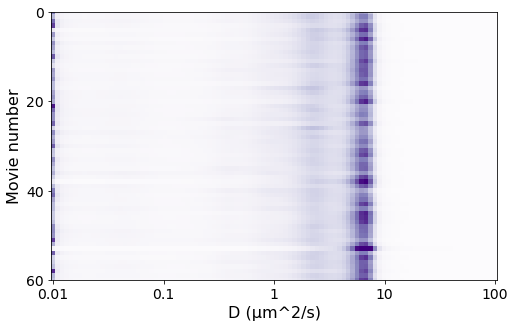

In [18]:
# plot diffusion spectrum for each file
fig, (ax1) = plt.subplots(1,1,figsize=[8,8],sharey=True)
ax1.imshow(po,cmap='Purples',vmin=0,vmax=0.1)
ax1.set_xlabel('D (µm^2/s)',fontsize=16)
ax1.set_ylabel('Movie number',fontsize=16)
# ax1.set_title('DR',fontsize=18)
ax1.set_xticks((np.arange(-2,3)+2)*99/4) # this looks weird, but it corresponds to even spacing on a log scale
ax1.set_xticklabels(['0.01','0.1','1','10','100'],fontsize=14)
ax1.set_yticks(np.arange(0,nfiles-1,20))
ax1.set_yticklabels(np.arange(0,nfiles-1,20),fontsize=14);

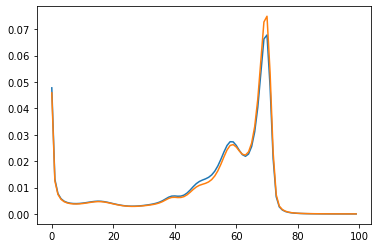

In [23]:
plt.plot(po[0:39,:].sum(0)/po[0:39,:].sum(0).sum())
plt.plot(po[39:,:].sum(0)/po[39:,:].sum(0).sum())